# Scaling laws in image classification

The performance of an image classification algorithm depens on three factors:
* complexity of a model,
* the amount of training data,
* the amount of computational resources.

To achieve best performance one has to make a careful tradeoff between these aspects. 
Note that there are usually hard limits on the amount of training data and the amount of computational resources.
In this tutorial, we fix a model and computational resources and consider how does the performance change if we add more data.
The corresponding scaling law gives an insight what is needed to get a better performance. 

We are going to work with [MNIST dataset](https://www.kaggle.com/datasets/hojjatk/mnist-dataset). 
Although the MNIST dataset is small we can still work out scaling laws. 
Later on we can improve the treatment and train an image generator on MNIST data that outputs potentially infinite dataset.

In [1]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from keras.optimizers import Adam
from plotnine import *

from model_library.display_code import display_source
from model_library.dataframe_manipulation import combine_two_dataframes

## I. Dataset prepararion

To simplify the task we are going to consider binary classification. 
More precisely, we are going to separate digits six and eight as they are quite similar and thus pose a challenge for classification.
To simplify further we are going to use balanced training ant test sets.

**Training data**
* We use equal number of digits six and digit eight. 
* We use tensors with dimensions $(N)$ as labels for $N\leq 5850$.
* We use tensors with dimension $(N, 28, 28)$ as input images.

**Test data**
* We use equal number of digits six and digit eight. 
* We use 950 images for each digit from the test set.

In [2]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist


# Load the MNIST dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

training_data = dict()
n_max = min(min(sum(train_labels == 6), sum(train_labels == 8)), 5850)
training_data['6'] = tf.random.shuffle(train_images[train_labels == 6]/255.0)[:n_max]
training_data['8'] = tf.random.shuffle(train_images[train_labels == 8]/255.0)[:n_max]
assert(len(training_data['6']) == len(training_data['8']))

test_data = dict()
n_max = min(min(sum(test_labels == 6), sum(test_labels == 8)), 950)
test_data['6'] = tf.random.shuffle(test_images[test_labels == 6]/255.0)[:n_max]
test_data['8'] = tf.random.shuffle(test_images[test_labels == 8]/255.0)[:n_max]
assert(len(test_data['6']) == len(test_data['8']))

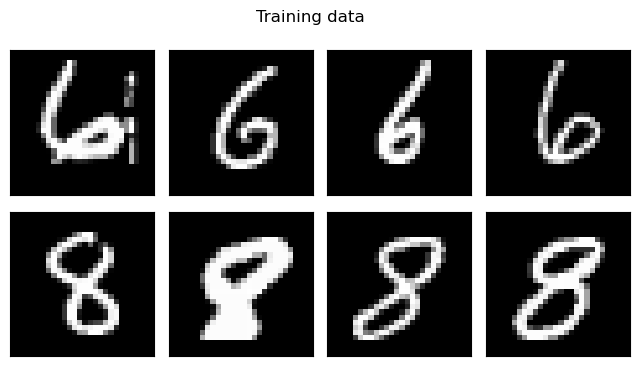

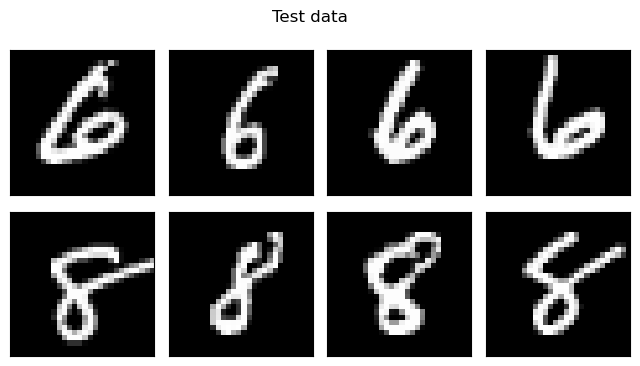

In [3]:
fig, axs = plt.subplots(2, 4, figsize=(8, 4))
plt.suptitle('Training data')
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.setp(axs, xticks=[], yticks=[], xlabel='', ylabel='', aspect='equal')
for i in range(4):
    axs[0, i].imshow(training_data['6'][i], cmap='gray', vmin=0, vmax=1)
    axs[1, i].imshow(training_data['8'][i], cmap='gray', vmin=0, vmax=1)
plt.show()

fig, axs = plt.subplots(2, 4, figsize=(8, 4))
plt.suptitle('Test data')
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.setp(axs, xticks=[], yticks=[], xlabel='', ylabel='', aspect='equal')
for i in range(4):
    axs[0, i].imshow(test_data['6'][i], cmap='gray', vmin=0, vmax=1)
    axs[1, i].imshow(test_data['8'][i], cmap='gray', vmin=0, vmax=1)
plt.show()

## II. Models to be trained 

We are going to consider two models implemented as `keras` neural networks:
* [Logistic regression model](https://en.wikipedia.org/wiki/Logistic_regression) -- a limited model that underfits the data;
* Convolutional neural network [Lenet5 by Yan Lecun](https://ieeexplore.ieee.org/document/726791) -- a rich model that is known to perform well on this data.

In [4]:
from model_library.logreg import mnist_logreg_model
logreg = mnist_logreg_model()
logreg.summary()
adam_lr = Adam(learning_rate=1e-3)
logreg.compile(optimizer=adam_lr, loss='binary_crossentropy', metrics=['accuracy'])

Model: "Logistic_regression"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           785 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 785 (3.07 KB)

 Trainable params: 785 (3.07 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
from model_library.lenet5 import mnist_binary_lenet5_model
lenet5 = mnist_binary_lenet5_model()
lenet5.summary()
adam_ln5 = Adam(learning_rate=5e-4)
lenet5.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=adam_ln5)

Model: "LeNet-5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 10, 10, 48)     │        38,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 48)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       307,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 84)             │        21,588 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 368,409 (1.41 MB)

 Trainable params: 368,409 (1.41 MB)

 Non-trainable params: 0 (0.00 B)

## III. Training routines 

We use a dedicated sampler to get a training set of fixed size and a deticated training function to train the model and get telementry.

In [6]:
from model_library.data_loaders import get_image_pairs
display_source(get_image_pairs)

```python
def get_image_pairs(n: int, source: Dict[str, tf.Tensor], class_0: str, class_1: str) -> Tuple[tf.Tensor, tf.Tensor]:
    """
    Loads first n samples of digits for both classes separately from the file, i.e., the outcome contains 2 * n samples.
    Final labels will be zero and one instead of original class labels defined as arguments.
    """
    if class_0 not in source or class_1 not in source:
        raise ValueError('Source has invalid format.')
    if n > len(source[class_0]) or n > len(source[class_1]):
        raise ValueError('Source does not contain enough samples.')
    if source[class_0][0].shape != (28, 28) or source[class_1][0].shape != (28, 28):
        raise ValueError('Source has invalid format: unexpected image sizes.')

    # Tensor magic to get interlaced training set
    images = tf.reshape(tf.stack([source[class_0][:n], source[class_1][:n]], axis=1), (-1, 28, 28))
    labels = tf.tile(tf.constant([0, 1], 'int32'), (n,))

    return images, labels

```

In [7]:
from model_library.model_training import train_binary_classifier
display_source(train_binary_classifier)

```python
def train_binary_classifier(
        model: keras.Model,
        images: tf.Tensor,
        labels: tf.Tensor,
        epochs: int = 100,
        batch_size: int = 32,
        collect_telemetry: bool = True,
        test_images: Optional[tf.Tensor] = None,
        test_labels: Optional[tf.Tensor] = None,
        **kwargs) -> Tuple[keras.Model, Optional[pd.DataFrame]]:
    """
    Trains binary classifier on training data and computes some telemetry data.
    By default, collects telemetry only about training data unless test data is also provided.
    Telemetry collection works under assumption that model is compiled with an argument metrics=['accuracy'].
    All additional arguments are directly passed to keras.Model.train_on_batch function.

    Return a trained model and a dataframe of collected telemetry about training.
    The dataframe contains one line per epoch and shows losses and accuracy on training and test datasets.
    """
    steps_per_epoch = len(images) // batch_size
    extra_block = bool(len(images) % batch_size)

    if len(images) != len(labels):
        raise ValueError('Invalid training data: Sample counts of images and labels do not match.')
    if (test_images is None) != (test_images is None):
        raise ValueError('Incomplete test data')

    telemetry = None
    collect_test_telemetry = False
    if collect_telemetry and (test_images is None):
        telemetry = (pd.DataFrame(range(epochs), columns=['epoch'])
                     .assign(training_loss=np.nan, training_accuracy=np.nan)
                     .set_index('epoch'))
    elif collect_telemetry and (test_images is not None):
        if len(test_images) != len(test_labels):
            raise ValueError('Invalid test data: Sample counts of images and labels do not match.')
        collect_test_telemetry = True
        telemetry = (pd.DataFrame(range(epochs), columns=['epoch'])
                     .assign(training_loss=np.nan, training_accuracy=np.nan)
                     .assign(test_loss=np.nan, test_accuracy=np.nan)
                     .set_index('epoch'))

    with tqdm(total=epochs, desc="Epoch Progress", unit="epoch") as pbar:
        for epoch in range(epochs):

            # Training
            for step in range(steps_per_epoch):
                start = step * batch_size
                end = start + batch_size
                model.train_on_batch(images[start:end], labels[start:end], **kwargs)
            if extra_block:
                start = steps_per_epoch * batch_size
                end = len(images)
                model.train_on_batch(images[start:end], labels[start:end], **kwargs)

            if not collect_telemetry:
                pbar.update(1)
                continue

            # Telemetry
            telemetry.loc[epoch, ['training_loss', 'training_accuracy']] = model.evaluate(images, labels, verbose=0)
            if collect_test_telemetry:
                telemetry.loc[epoch, ['test_loss', 'test_accuracy']] = model.evaluate(test_images, test_labels, verbose=0)
            pbar.update(1)

    return model, telemetry

```

**Example run**

Let first generate a really small training set and a test set of 1900 elements.

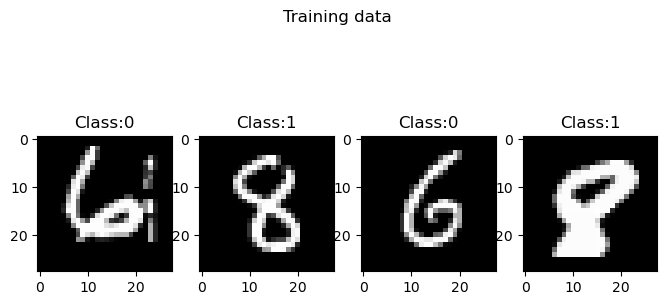

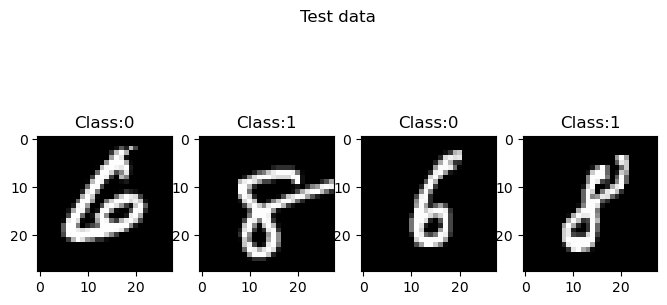

In [8]:
images, labels = get_image_pairs(2, training_data, '6', '8')
fig, axs = plt.subplots(1, 4, figsize=(8, 4))
plt.suptitle('Training data')
for i in range(0, 4): 
    axs[i].imshow(images[i], cmap='gray', vmin=0, vmax=1)
    axs[i].set_title(f'Class:{labels[i]}')

test_images, test_labels = get_image_pairs(950, test_data, '6', '8')
fig, axs = plt.subplots(1, 4, figsize=(8, 4))
plt.suptitle('Test data')
for i in range(0, 4): 
    axs[i].imshow(test_images[i], cmap='gray', vmin=0, vmax=1)
    axs[i].set_title(f'Class:{test_labels[i]}')
assert len(test_images) == 1900

Now we can train the model and see the instrumentation.

Epoch Progress:   0%|          | 0/100 [00:00<?, ?epoch/s]

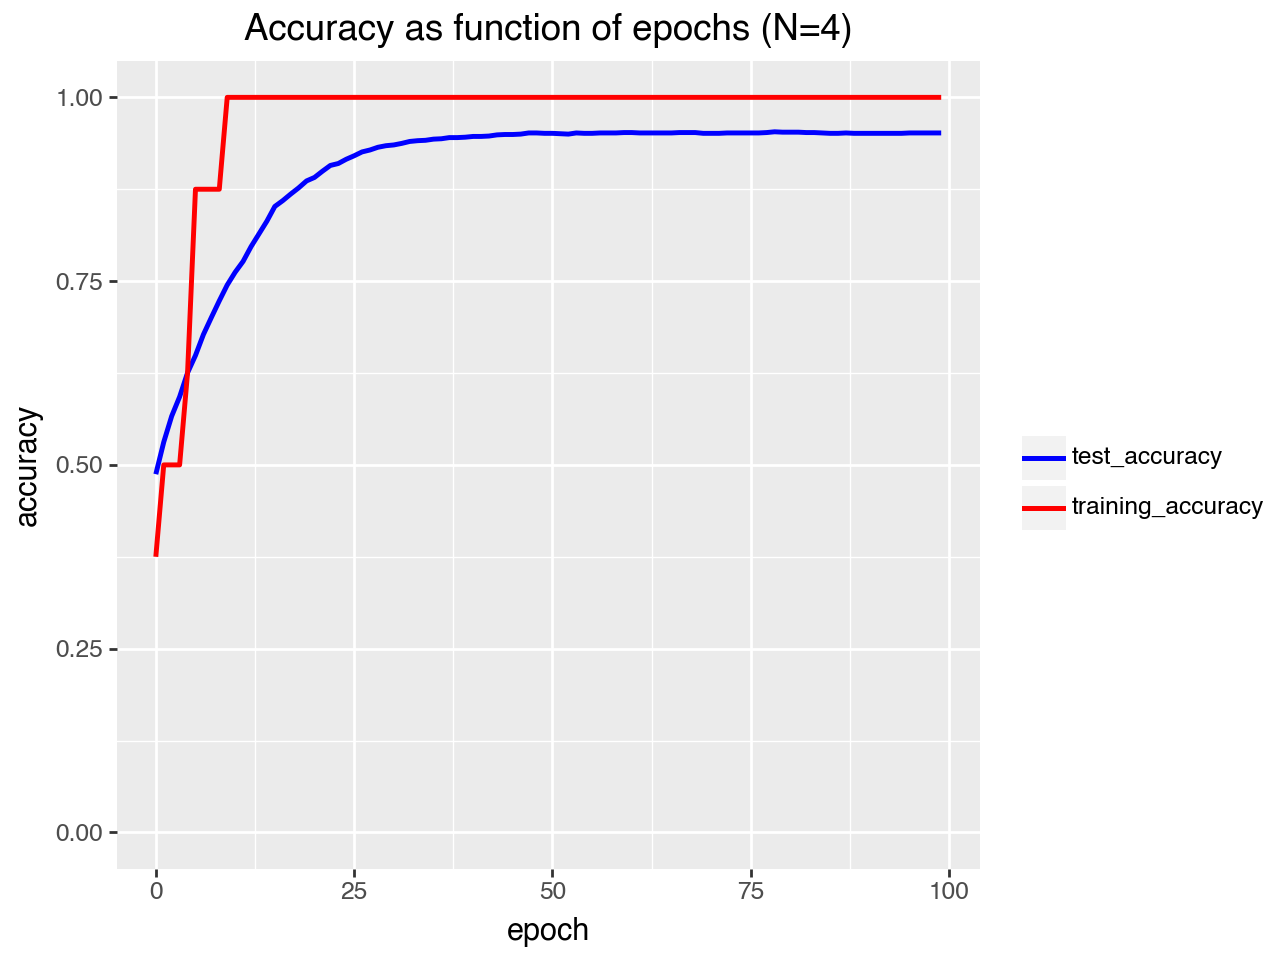

In [9]:
logreg = mnist_logreg_model()
adam_lr = Adam(learning_rate=1e-3)
logreg.compile(optimizer=adam_lr, loss='binary_crossentropy', metrics=['accuracy'])

N = 4
images, labels = get_image_pairs(N, training_data, '6', '8')
logreg, telemetry = train_binary_classifier(
    logreg, images, labels , epochs=100, batch_size=32, test_images=test_images, test_labels=test_labels)

# Visualise result
data = pd.melt(telemetry.reset_index(), id_vars=['epoch'],
               value_vars=['training_accuracy', 'test_accuracy'], 
               var_name='set', value_name='accuracy') 
data['accuracy'] = data['accuracy'].astype(float)
p  = ggplot(data) 
p += geom_line(aes(x='epoch', y='accuracy', color='set'), size=1)
p += scale_color_manual(values={'training_accuracy': 'red', 'test_accuracy': 'blue'}, name= ' ')
p += ylim([0,1])
p += ggtitle(f'Accuracy as function of epochs (N={N})')
p

**Lecture illustration**

```
p  = ggplot(data) 
p += geom_line(aes(x='epoch', y='accuracy', color='set'), size=1)
p += scale_color_manual(values={'training_accuracy': 'red', 'test_accuracy': 'blue'}, name= ' ')
p += ylim([0,1])
p += theme(legend_position=(0.95, 0.05))
p.save(filename='../../results/scaling-law-i.pdf', width=6, height=4, units='in')
````

Epoch Progress:   0%|          | 0/100 [00:00<?, ?epoch/s]

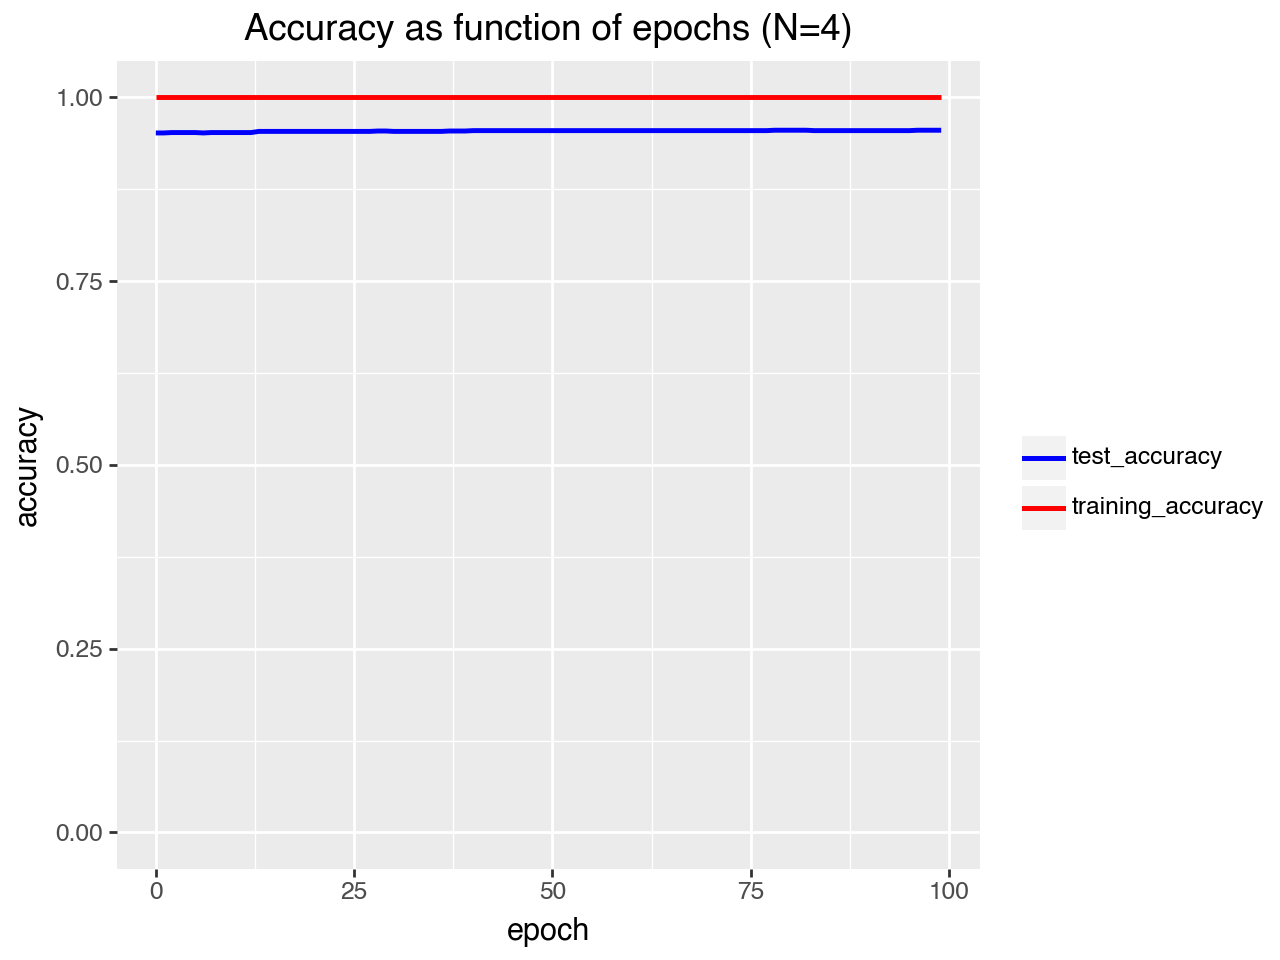

In [10]:
lenet5 = mnist_binary_lenet5_model()
adam_ln5 = Adam(learning_rate=5e-4)
lenet5.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=adam_ln5)

N = 4
images, labels = get_image_pairs(N, training_data, '6', '8')
logreg, telemetry = train_binary_classifier(
    logreg, images, labels , epochs=100, batch_size=32, test_images=test_images, test_labels=test_labels)

# Visualise result
data = pd.melt(telemetry.reset_index(), id_vars=['epoch'],
               value_vars=['training_accuracy', 'test_accuracy'], 
               var_name='set', value_name='accuracy') 
data['accuracy'] = data['accuracy'].astype(float)
p  = ggplot(data) 
p += geom_line(aes(x='epoch', y='accuracy', color='set'), size=1)
p += scale_color_manual(values={'training_accuracy': 'red', 'test_accuracy': 'blue'}, name= ' ')
p += ylim([0,1])
p + ggtitle(f'Accuracy as function of epochs (N={N})')

## IV. Scaling laws for logistic regression

By some odd reason logistic regression is really good at splitting numbers. MNIST dataset is linearly separable and there is no need for higher order features. Nevertheless, we can still see how the amount of data influences accuracy if we use only few epochs.  

In [11]:
N = list(range(0, 101, 10))[1:]
lr_scaling_1 = pd.DataFrame({'N': N}).assign(training_accuracy=None, test_accuracy=None).set_index('N')

for n in N:
    logreg = mnist_logreg_model()
    adam_lr = Adam(learning_rate=1e-3)
    logreg.compile(optimizer=adam_lr, loss='binary_crossentropy', metrics=['accuracy'])

    images, labels = get_image_pairs(n, training_data, '6', '8')
    logreg, _ = train_binary_classifier(logreg, images, labels , epochs=10, batch_size=32, collect_telemetry=False)

    # Collect telemetry
    lr_scaling_1.loc[n, 'training_accuracy'] = logreg.evaluate(images, labels, verbose=0)[1]
    lr_scaling_1.loc[n, 'test_accuracy'] = logreg.evaluate(test_images, test_labels, verbose=0)[1]  



Epoch Progress:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch Progress:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch Progress:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch Progress:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch Progress:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch Progress:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch Progress:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch Progress:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch Progress:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch Progress:   0%|          | 0/10 [00:00<?, ?epoch/s]

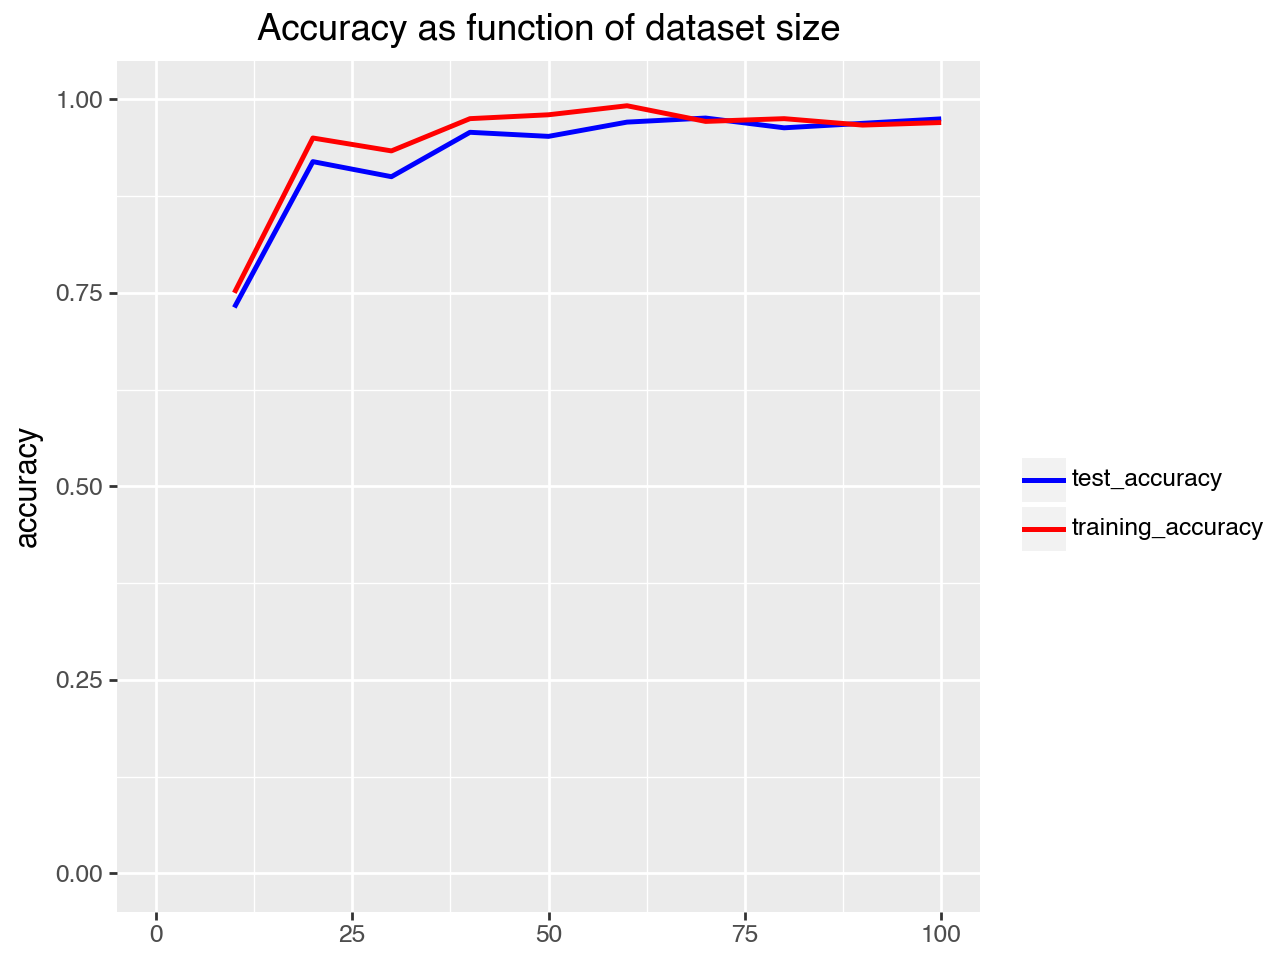

In [12]:
# Visualise result
data = pd.melt(lr_scaling_1.reset_index(), id_vars=['N'],
               value_vars=['training_accuracy', 'test_accuracy'], 
               var_name='set', value_name='accuracy') 
data['accuracy'] = data['accuracy'].astype(float)
p  = ggplot(data) 
p += geom_line(aes(x='N', y='accuracy', color='set'), size=1)
p += scale_color_manual(values={'training_accuracy': 'red', 'test_accuracy': 'blue'}, name= ' ')
p += ylim([0,1])
p += xlim([0, 100])
p += xlab('')
p + ggtitle(f'Accuracy as function of dataset size')

**Lecture illustration**

```
data = pd.melt(lr_scaling.reset_index(), id_vars=['N'],
               value_vars=['training_accuracy', 'test_accuracy'], 
               var_name='set', value_name='accuracy') 
data['accuracy'] = data['accuracy'].astype(float)
p  = ggplot(data) 
p += geom_line(aes(x='N', y='accuracy', color='set'), size=1)
p += scale_color_manual(values={'training_accuracy': 'red', 'test_accuracy': 'blue'}, name= ' ')
p += ylim([0,1])
p += xlim([0, 100])
p += xlab('sample count')
p + ggtitle(f'Accuracy as function of dataset size')
p += theme(legend_position=(0.95, 0.05))
p.save(filename='../../results/scaling-law-ii.pdf', width=6, height=4, units='in')
```

Lets run the analysis one more time just to be sure.

In [13]:
N = list(range(0, 100, 10))[1:]
lr_scaling_2 = pd.DataFrame({'N': N}).assign(training_accuracy=None, test_accuracy=None).set_index('N')

for n in N:
    logreg = mnist_logreg_model()
    adam_lr = Adam(learning_rate=1e-3)
    logreg.compile(optimizer=adam_lr, loss='binary_crossentropy', metrics=['accuracy'])

    images, labels = get_image_pairs(n, training_data, '6', '8')
    logreg, _ = train_binary_classifier(logreg, images, labels , epochs=10, batch_size=32, collect_telemetry=False)

    # Collect telemetry
    lr_scaling_2.loc[n, 'training_accuracy'] = logreg.evaluate(images, labels, verbose=0)[1]
    lr_scaling_2.loc[n, 'test_accuracy'] = logreg.evaluate(test_images, test_labels, verbose=0)[1]  

Epoch Progress:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch Progress:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch Progress:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch Progress:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch Progress:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch Progress:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch Progress:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch Progress:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch Progress:   0%|          | 0/10 [00:00<?, ?epoch/s]

In [14]:
combine_two_dataframes(lr_scaling_1.reset_index(), lr_scaling_2.reset_index(), ('A', 'B'), 'N')

N test_accuracy           training_accuracy          
    -             A         B                 A         B
0  10      0.731053  0.737895              0.75      0.75
1  20      0.919474  0.925263              0.95     0.975
2  30           0.9  0.958421          0.933333  0.983333
3  40      0.957368  0.929474             0.975    0.9375
4  50      0.952105  0.945263              0.98      0.94
5  60      0.970526  0.962105          0.991667  0.966667
6  70      0.975789  0.961053          0.971429  0.971429
7  80      0.963158  0.966316             0.975   0.96875
8  90      0.968947  0.976842          0.966667  0.977778

## V. Why do we get different numbers in different runs?

### Model initialisation is randomised

Weights of the model is initalised differently for each training run.

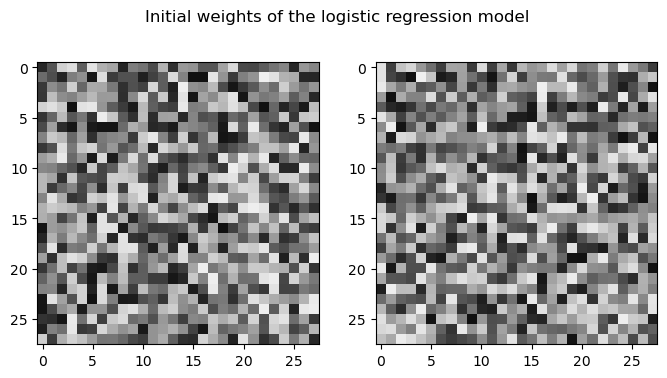

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
plt.suptitle('Initial weights of the logistic regression model')
for i in range(0, 2): 
    logreg = mnist_logreg_model()
    model_weights = tf.reshape(logreg.get_weights()[0], (28,28))
    axs[i].imshow(model_weights, cmap='gray', vmin=-0.1, vmax=0.1)
   

In [16]:
from tensorflow.keras.models import clone_model

If we fix initial weights we do not get the same results for logistic regression model as the training process contains additional randomness.

In [17]:
N = list(range(0, 100, 10))[1:]
lr_scaling = pd.DataFrame({'N': N}).assign(test_accuracy_1=None, test_accuracy_2=None).set_index('N')
base_model = mnist_logreg_model()

for n in N:
    # Lets use same initail weights
    logreg = clone_model(base_model)
    adam_lr = Adam(learning_rate=1e-3)
    logreg.compile(optimizer=adam_lr, loss='binary_crossentropy', metrics=['accuracy'])

    images, labels = get_image_pairs(n, training_data, '6', '8')
    logreg, _ = train_binary_classifier(logreg, images, labels , epochs=10, batch_size=32, collect_telemetry=False)

    # Collect telemetry
    lr_scaling.loc[n, 'test_accuracy_1'] = logreg.evaluate(test_images, test_labels, verbose=0)[1]

    logreg = clone_model(base_model)
    adam_lr = Adam(learning_rate=1e-3)
    logreg.compile(optimizer=adam_lr, loss='binary_crossentropy', metrics=['accuracy'])

    images, labels = get_image_pairs(n, training_data, '6', '8')
    logreg, _ = train_binary_classifier(logreg, images, labels , epochs=10, batch_size=32, collect_telemetry=False)

    # Collect telemetry
    lr_scaling.loc[n, 'test_accuracy_2'] = logreg.evaluate(test_images, test_labels, verbose=0)[1]
lr_scaling

Epoch Progress:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch Progress:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch Progress:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch Progress:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch Progress:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch Progress:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch Progress:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch Progress:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch Progress:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch Progress:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch Progress:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch Progress:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch Progress:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch Progress:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch Progress:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch Progress:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch Progress:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch Progress:   0%|          | 0/10 [00:00<?, ?epoch/s]

,test_accuracy_1,test_accuracy_2
N,,
10,0.740526,0.896316
20,0.910526,0.863158
30,0.878947,0.948421
40,0.933684,0.956842
50,0.964737,0.944211
60,0.964737,0.961053
70,0.956316,0.963684
80,0.975263,0.967368
90,0.974737,0.971579


### Test set choice is also random

Usually there more than one way to choose a test set or the test set evolves as we get new labelled samples.
For instance, if we decide to choose a random 1000 element test set, then there are lot of freedom  in choices.  

In [18]:
small_testset_1 = tf.random.shuffle(tf.range(1900))[:1000]
small_testset_2 = tf.random.shuffle(tf.range(1900))[:1000]

In [19]:
N = list(range(0, 100, 10))[1:]
lr_scaling = pd.DataFrame({'N': N}).assign(test_accuracy_1=None, test_accuracy_2=None).set_index('N')
base_model = mnist_logreg_model()

for n in N:
    # Lets use same initail weights
    logreg = clone_model(base_model)
    adam_lr = Adam(learning_rate=1e-3)
    logreg.compile(optimizer=adam_lr, loss='binary_crossentropy', metrics=['accuracy'])

    images, labels = get_image_pairs(n, training_data, '6', '8')
    logreg, _ = train_binary_classifier(logreg, images, labels , epochs=10, batch_size=32, collect_telemetry=False)

    # Collect telemetry on small test set 1
    lr_scaling.loc[n, 'test_accuracy_1'] = logreg.evaluate(
        tf.gather(test_images, small_testset_1), 
        tf.gather(test_labels, small_testset_1), verbose=0)[1]

    # Collect telemetry on small test set 2
    lr_scaling.loc[n, 'test_accuracy_2'] = logreg.evaluate(
        tf.gather(test_images, small_testset_2), 
        tf.gather(test_labels, small_testset_2), verbose=0)[1]
    

Epoch Progress:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch Progress:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch Progress:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch Progress:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch Progress:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch Progress:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch Progress:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch Progress:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch Progress:   0%|          | 0/10 [00:00<?, ?epoch/s]

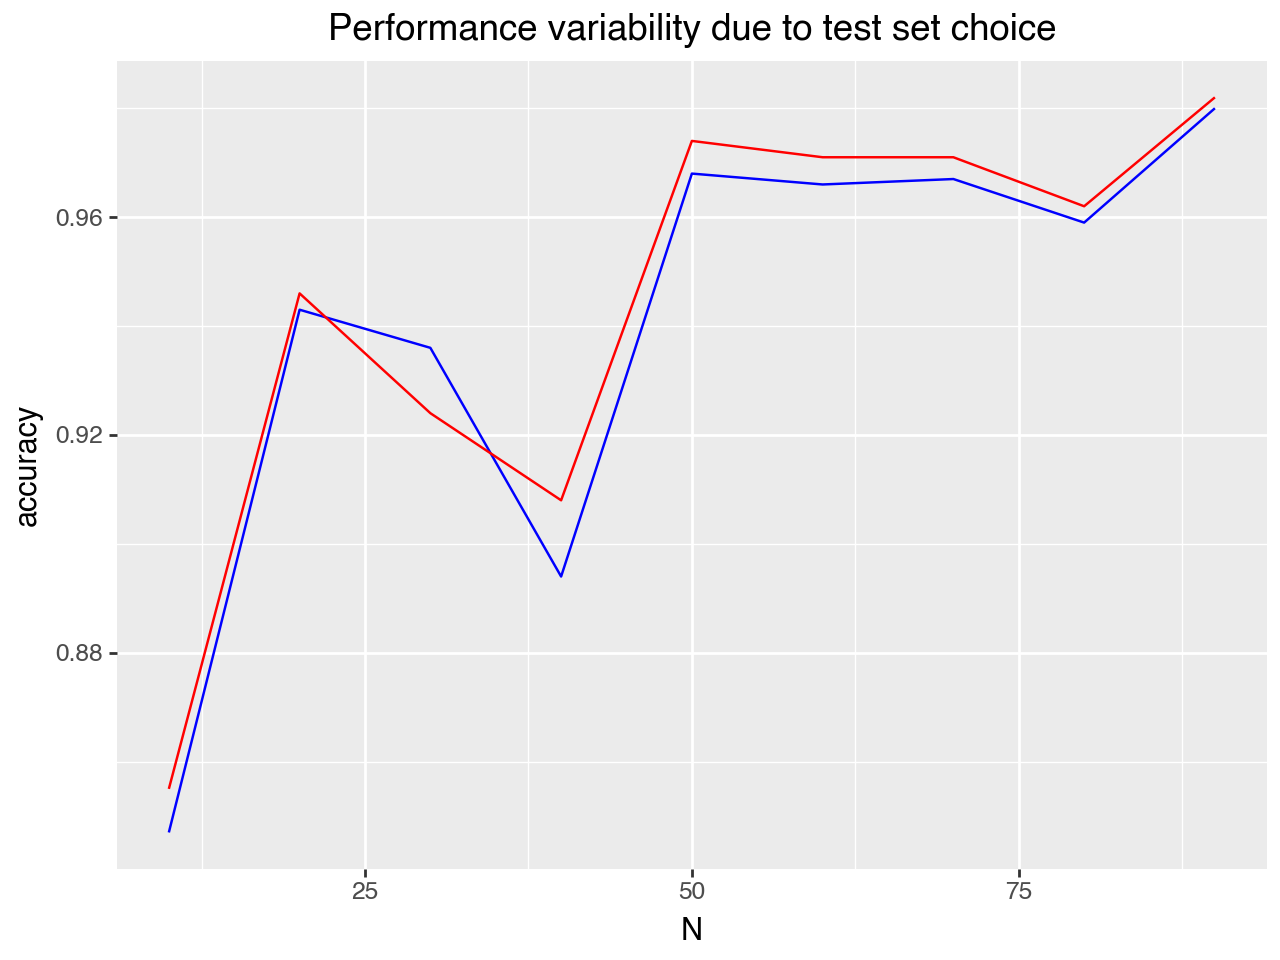

In [20]:
# Lets visualise the difference
data = lr_scaling.reset_index()
data['test_accuracy_1'] = data['test_accuracy_1'].astype(float)
data['test_accuracy_2'] = data['test_accuracy_2'].astype(float)
p  = ggplot(data) 
p += geom_line(aes(x='N', y='test_accuracy_1'), color='blue') 
p += geom_line(aes(x='N', y='test_accuracy_2'), color='red')
p += ylab('accuracy')
p += ggtitle('Performance variability due to test set choice')
p

### Training set is also random

There are  more than one way to choose training set samples. Each coice gives a different model andthus also a different performance even if we use the same test set. 

In [21]:
N = list(range(0, 100, 10))[1:]
lr_scaling = pd.DataFrame({'N': N}).assign(test_accuracy_1=None, test_accuracy_2=None).set_index('N')
base_model = mnist_logreg_model()

training_data_2 = dict()
training_data_2['6'] = tf.random.shuffle(training_data['6'])
training_data_2['8'] = tf.random.shuffle(training_data['8'])

for n in N:
    # Lets use same initail weights
    logreg = clone_model(base_model)
    adam_lr = Adam(learning_rate=1e-3)
    logreg.compile(optimizer=adam_lr, loss='binary_crossentropy', metrics=['accuracy'])

    images, labels = get_image_pairs(n, training_data, '6', '8')
    logreg, _ = train_binary_classifier(logreg, images, labels , epochs=10, batch_size=32, collect_telemetry=False)

    # Collect telemetry
    lr_scaling.loc[n, 'test_accuracy_1'] = logreg.evaluate(test_images, test_labels, verbose=0)[1]

    logreg = clone_model(base_model)
    adam_lr = Adam(learning_rate=1e-3)
    logreg.compile(optimizer=adam_lr, loss='binary_crossentropy', metrics=['accuracy'])

    images, labels = get_image_pairs(n, training_data_2, '6', '8')
    logreg, _ = train_binary_classifier(logreg, images, labels , epochs=10, batch_size=32, collect_telemetry=False)

    # Collect telemetry
    lr_scaling.loc[n, 'test_accuracy_2'] = logreg.evaluate(test_images, test_labels, verbose=0)[1]

Epoch Progress:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch Progress:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch Progress:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch Progress:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch Progress:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch Progress:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch Progress:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch Progress:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch Progress:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch Progress:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch Progress:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch Progress:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch Progress:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch Progress:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch Progress:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch Progress:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch Progress:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch Progress:   0%|          | 0/10 [00:00<?, ?epoch/s]

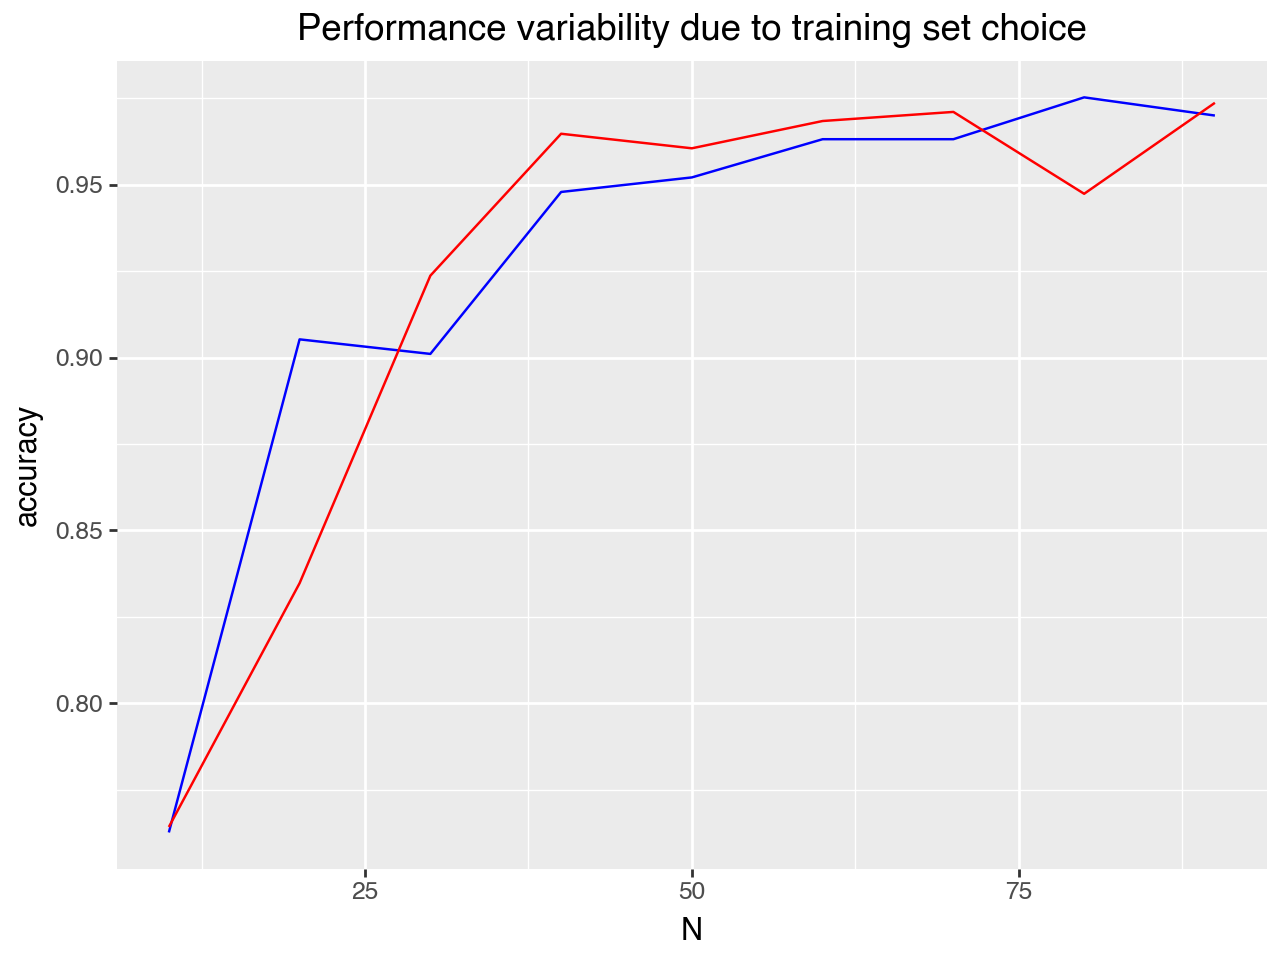

In [22]:
# Lets visualise the difference
data = lr_scaling.reset_index()
data['test_accuracy_1'] = data['test_accuracy_1'].astype(float)
data['test_accuracy_2'] = data['test_accuracy_2'].astype(float)
p  = ggplot(data) 
p += geom_line(aes(x='N', y='test_accuracy_1'), color='blue') 
p += geom_line(aes(x='N', y='test_accuracy_2'), color='red')
p += ylab('accuracy')
p += ggtitle('Performance variability due to training set choice')
p

## VI. Can we trust the scaling graph?

A scaling graph is and epirical tool to decide what should we do:
* Do we need to collect more data samples?
* Do we need to buy more compute?
* Do we need to use a more complicated model?

Unfortunately, all three sources of randomness make our life harder. The problem is a specially important when we run the model in production and have continious upgrade process.